In [1]:
#7/5/24 For the creation of an Autoencoder for Feature Extraction
#The goal is to create an autoencoder that can parse SMILES via one hot encoding or a graphical representation
#Main steps:
    #One hot encoding SMILES DONE
    #import into autoencoder
    #train to recreate SMILES
    #use latent space for feature prediction
#Mostly for testing, one hot data is too large to parse into jupyter
#Will test on drug target data
#Even though an autoencoder model was already developed, due to the poor results it has shown
#It has been totally rewritten
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
#Data import
targetdata = pd.read_csv('/Users/james/Documents/Honours/Data/Targetdata/Endo/DrugTargets.csv')


####################
#Todo: iterate over multiple epoch size, batchsize and latent space sizes
#maintain seed
#store best model

In [2]:
#Creating test/train splits
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(targetdata, test_size=0.2, random_state=82)
#Converts Toxicity Values to a list
ytrain = trainset['Toxicity_Value'].to_list
ytest = testset['Toxicity_Value']
#Converts encoded drug target values to an array
xtrain = trainset.iloc[:, 2:].values
xtest = testset.iloc[:, 2:].values

In [3]:
import tensorflow as tf
from tensorflow import keras

# Determines layer size and input/output
# Here it turns the 334 one hot encoded features to 42
#latent_space = 42
latent_space = 12
keras.utils.set_random_seed(81)
tf.config.experimental.enable_op_determinism()
length = len(xtrain[0])

# Encoder Creation
enc_in = keras.Input(shape=(length, 1))
x = keras.layers.Flatten()(enc_in)

# Additional encoder layers
x = keras.layers.Dense(160, activation="relu")(x)
x = keras.layers.Dense(81, activation="relu")(x)
x = keras.layers.Dense(42, activation="relu")(x)

enc_out = keras.layers.Dense(latent_space, activation="relu")(x)
encoder = keras.Model(enc_in, enc_out, name='relu')

# Decoder Creation
decoder_in = keras.layers.Dense(latent_space, activation='relu')(enc_out)

# Additional decoder layers
x = keras.layers.Dense(42, activation='relu')(decoder_in)
x = keras.layers.Dense(81, activation='relu')(x)
x = keras.layers.Dense(160, activation='relu')(x)

x = keras.layers.Dense(length, activation='sigmoid')(x)
decoder_out = keras.layers.Reshape((length,1))(x)

# Optimiser
optimise = tf.keras.optimizers.Adam(learning_rate = 0.001)

# Model Creation
autoencoder = keras.Model(enc_in, decoder_out, name='autoencoder')

autoencoder.compile(optimise, loss='binary_crossentropy')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 334, 1)]          0         
                                                                 
 flatten (Flatten)           (None, 334)               0         
                                                                 
 dense (Dense)               (None, 160)               53600     
                                                                 
 dense_1 (Dense)             (None, 81)                13041     
                                                                 
 dense_2 (Dense)             (None, 42)                3444      
                                                                 
 dense_3 (Dense)             (None, 12)                516       
                                                                 
 dense_4 (Dense)             (None, 12)                

In [4]:
#Runs and creates the autoencoder and outputs parameters to a specs file
epochs = 1000
batchsize = 3
losshistory = []
vallosshistory = []
for epoch in range(epochs):
    logs = autoencoder.fit(
    xtrain,
    xtrain,
    epochs=1,
    batch_size=batchsize, validation_split=0.2)
    
    #autoencoder.save(str(f"models/AE-{epoch+1}.keras"))
    #autoencoder.save(str(f"models/AE-{epoch+1}.keras"))
    losshistory.append(logs.history['loss'])
    vallosshistory.append(logs.history['val_loss'])
    
    

2826/2826 [==============================] - 2s 812us/step - loss: 0.0473 - val_loss: 0.0740


2826/2826 [==============================] - 2s 790us/step - loss: 0.0443 - val_loss: 0.0785


2826/2826 [==============================] - 2s 803us/step - loss: 0.0437 - val_loss: 0.0791


2826/2826 [==============================] - 2s 810us/step - loss: 0.0436 - val_loss: 0.0792


2826/2826 [==============================] - 3s 965us/step - loss: 0.0428 - val_loss: 0.0834


2826/2826 [==============================] - 3s 906us/step - loss: 0.0430 - val_loss: 0.0857


2826/2826 [==============================] - 3s 904us/step - loss: 0.0450 - val_loss: 0.0843


2826/2826 [==============================] - 3s 905us/step - loss: 0.0431 - val_loss: 0.0917


2826/2826 [==============================] - 2s 835us/step - loss: 0.0435 - val_loss: 0.0848


2826/2826 [==============================] - 2s 822us/step - loss: 0.0434 - val_loss: 0.0844


2826/2826 [==============================] - 3s 885us/step - loss: 0.0430 - val_loss: 0.0852


2826/2826 [==============================] - 2s 853us/step - loss: 0.0464 - val_loss: 0.0874


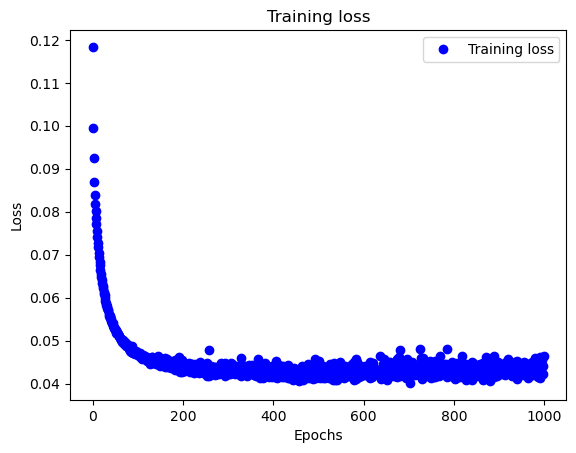

In [13]:
import matplotlib.pyplot as plt
epochcount = range(epochs)
plt.figure()
plt.plot(epochcount, losshistory, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [7]:
toxtest = []
for items in ytest:
    toxtest.append(items)

#colcount = len(xtest[0])
colcount = len(xtrain[0])
#ae_out = autoencoder.predict([ xtrain.reshape(-1, colcount, 1) ])
ae_out = autoencoder.predict([ xtest.reshape(-1, colcount, 1) ])
outsize = len(ae_out)
predictions = ae_out.reshape(outsize,colcount)

83/83 [==============================] - 0s 502us/step


In [8]:
#Function to calculate fpr and tpr given a set of predictions, a threshold and the acutal data
def ratecalc(predictions, threshold, xtest):
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0

    iterations = 0
    for samples in predictions:
        loops = 0
        for value in predictions[iterations]:
            testscore = xtest[iterations][loops]
            #testscore = xtrain[iterations][loops]
            if value > threshold:
                if testscore != 0:
                    tpcount = tpcount + 1
                else:
                    fpcount = fpcount + 1
            else:
                if testscore != 0:
                    fncount = fncount + 1
                else:
                    tncount = tncount + 1

            loops = loops + 1
    
    fpr = fpcount / (fpcount + tncount)
    tpr = tpcount / (tpcount + fncount)
    
    return(fpr, tpr)

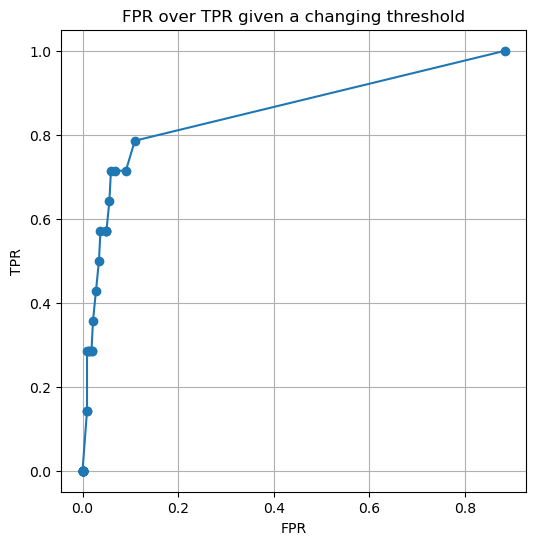

In [9]:
#ROC curve creation
ratelist = []
for threshold in np.arange(0, 2.1, 0.05):
    ratelist.append(ratecalc(predictions, threshold, xtest))

import matplotlib.pyplot as plt
x_values = [x for x, y in ratelist]
y_values = [y for x, y in ratelist]

# Create the plot
plt.figure(figsize=(6, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Add titles and labels
plt.title('FPR over TPR given a changing threshold')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Display the plot
plt.grid(True)
plt.show()

In [10]:
#Function to calculate net accuracy in relation to threshold
import math

def acccalc(predictions, threshold, xtest):
    correctcount = 0
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0
    testpos = 0
    testneg = 0

    iterations = 0
    for samples in predictions:
        loops = 0
        for value in predictions[iterations]:
            testscore = xtest[iterations][loops]
            #testscore = xtrain[iterations][loops]
            if value > threshold:
                if testscore != 0:
                    testpos = testpos + 1
                    correctcount = correctcount + 1
                    tpcount = tpcount + 1
                else:
                    fpcount = fpcount + 1
                    testneg = testneg + 1
            else:
                if testscore != 0:
                    testpos = testpos + 1
                    fncount = fncount + 1
                else:
                    testneg = testneg + 1
                    correctcount = correctcount + 1
                    tncount = tncount + 1

            loops = loops + 1
        
    #netacc = correctcount / (fpcount + fncount + tpcount + tncount)
    #netfn = fncount / (fncount + tncount)
    #nettn = tncount / (fncount + tncount)
    #netacc = correctcount / (fpcount + fncount + tpcount + tncount)
    posacc = tpcount / testpos
    #negacc = tncount / testneg
    #netfp = fpcount / (fpcount + tpcount)
    #nettp = tpcount / (tpcount + fpcount)
    #f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)
    
    tp = tpcount
    fp = fpcount
    tn = tncount
    fn = fncount
    
    temp = math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))
    if temp == 0:
        return(0)
    mcc = ((tp * tn) - (fp * fn)) / temp
    
#    temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
#    if temp == 0:
#        return(0)
#    kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp

    return(mcc)

colcount = len(xtest[0])
#ae_out = autoencoder.predict([ xtest.reshape(-1, colcount, 1) ])
#predictions = ae_out.reshape(2649,colcount)

toxtest = []
for items in ytest:
    toxtest.append(items)


optimal paramers at y= 0.466092574296071 x= 0.18


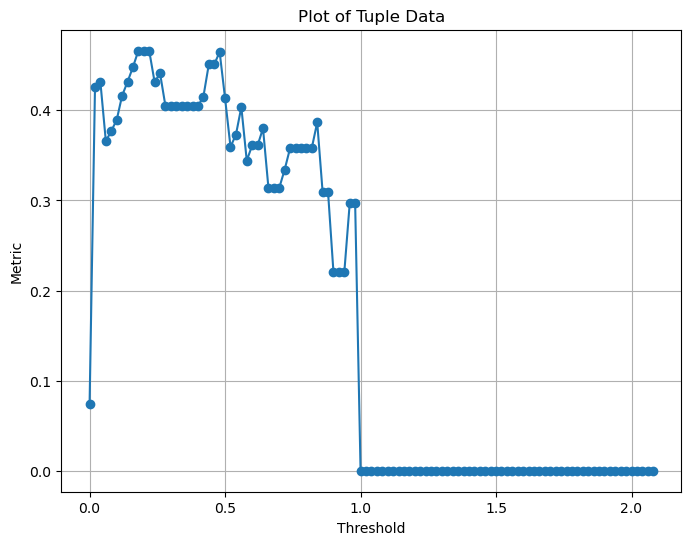

In [11]:
#Metric curve creation
acclist = []
thresholdlist = []
for threshold in np.arange(0, 2.1, 0.02):
    acclist.append(acccalc(predictions, threshold, xtest))
    thresholdlist.append(threshold)

import matplotlib.pyplot as plt
y_values = acclist
x_values = thresholdlist

max_y = max(y_values)
max_x = x_values[y_values.index(max_y)]

print('optimal paramers at y=', max_y, 'x=', max_x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Add titles and labels
plt.title('Plot of Tuple Data')
plt.ylabel('Metric')
plt.xlabel('Threshold')

# Display the plot
plt.grid(True)
plt.show()

In [12]:
#Generic Metric testing for a given threshold
correctcount = 0
fpcount = 0
tpcount = 0
tncount = 0
fncount = 0
testpos = 0
testneg = 0

iterations = 0
for samples in predictions:
    loops = 0
    for value in predictions[iterations]:
        testscore = xtest[iterations][loops]
        #testscore = xtrain[iterations][loops]
        if value > max_x:
            if testscore != 0:
                testpos = testpos + 1
                correctcount = correctcount + 1
                tpcount = tpcount + 1
            else:
                fpcount = fpcount + 1
                testneg = testneg + 1
        else:
            if testscore != 0:
                testpos = testpos + 1
                fncount = fncount + 1
            else:
                testneg = testneg + 1
                correctcount = correctcount + 1
                tncount = tncount + 1
                
        loops = loops + 1

print('threshold =', max_x)
print('specs:')
print('epochs =', epochs, 'batchsize =', batchsize, 'latent space =', latent_space, 'layers =', '160, 81, 42', '\n')

print('positives in data', testpos)
print('negatives in data', testneg, '\n')

print('fn count =', fncount)
print('tn count =', tncount)

print('tp count =', tpcount)
print('fp count =', fpcount, '\n')

netfn = fncount / (fncount + tncount)
nettn = tncount / (fncount + tncount)
netacc = correctcount / (fpcount + fncount + tpcount + tncount)
posacc = tpcount / testpos
negacc = tncount / testneg
netfp = fpcount / (fpcount + tpcount)
nettp = tpcount / (tpcount + fpcount)

print('net accuracy =', netacc)
print('positive accuracy =', posacc)
print('negative accuracy =', negacc, '\n')

fpr = fpcount / (fpcount + tncount)
tpr = tpcount / (tpcount + fncount)

print('fpr =', fpr)
print('tpr =', tpr, '\n')

f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)
print('f1 score =',f1)

tp = tpcount
fp = fpcount
tn = tncount
fn = fncount

mcc = ((tp * tn) - (fp * fn)) / math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))

print('mcc =',mcc)

temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp

print('cohen Kappa =',kapp)


threshold = 0.18
specs:
epochs = 1000 batchsize = 3 latent space = 12 layers = 160, 81, 42 

positives in data 37086
negatives in data 847680 

fn count = 10596
tn count = 797349
tp count = 26490
fp count = 50331 

net accuracy = 0.9311377245508982
positive accuracy = 0.7142857142857143
negative accuracy = 0.940625 

fpr = 0.059375
tpr = 0.7142857142857143 

f1 score = 0.46511627906976744
mcc = 0.466092574296071
cohen Kappa = 0.43306273062730627


In [ ]:
threshold = 0.36
specs:
epochs = 7 batchsize = 3 latent space = 12 layers = 160, 81, 42 

positives in data 37086
negatives in data 847680 

fn count = 10596
tn count = 842382
tp count = 26490
fp count = 5298 

net accuracy = 0.9820359281437125
positive accuracy = 0.7142857142857143
negative accuracy = 0.99375 

fpr = 0.00625
tpr = 0.7142857142857143 

f1 score = 0.7692307692307693
mcc = 0.7623872291645094
cohen Kappa = 0.7599425011978918


In [ ]:
autoencoder.save('bing.keras')
autoencoder = keras.models.load_model('/Users/james/Documents/Honours/Python/Target_Selection/Drug_Targets/autoencode/bing.keras')